<a href="https://colab.research.google.com/github/Sauravkrgupta/Data-Science-Assignment/blob/main/Saurav_Kumar_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import pandas as pd

In [61]:
# Load datasets
customers = pd.read_csv("Customers.csv")

In [62]:
transactions = pd.read_csv("Transactions.csv")

In [63]:
# Merge customers and transactions
data = transactions.merge(customers, on="CustomerID", how="inner")

In [64]:
# Aggregate transaction data for each customer
customer_data = data.groupby("CustomerID").agg(
    TotalSpent=("TotalValue", "sum"),
    TotalTransactions=("TransactionID", "count"),
    TotalQuantity=("Quantity", "sum"),
    AvgTransactionValue=("TotalValue", "mean")
).reset_index()

In [65]:
# Merge back region data
customer_data = customer_data.merge(customers[["CustomerID", "Region"]], on="CustomerID")

In [66]:
print(customer_data.head())

  CustomerID  TotalSpent  TotalTransactions  TotalQuantity  \
0      C0001     3354.52                  5             12   
1      C0002     1862.74                  4             10   
2      C0003     2725.38                  4             14   
3      C0004     5354.88                  8             23   
4      C0005     2034.24                  3              7   

   AvgTransactionValue         Region  
0              670.904  South America  
1              465.685           Asia  
2              681.345  South America  
3              669.360  South America  
4              678.080           Asia  


In [67]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [68]:
# Encode categorical variables
le = LabelEncoder()

In [69]:
customer_data["Region"] = le.fit_transform(customer_data["Region"])

In [70]:

# Select features for clustering
features = customer_data[["TotalSpent", "TotalTransactions", "TotalQuantity", "AvgTransactionValue", "Region"]]


In [71]:
# Scale the features
scaler = StandardScaler()

In [72]:
scaled_features = scaler.fit_transform(features)

In [73]:
print(scaled_features[:5])

[[-0.06170143 -0.01145819 -0.12203296 -0.07026341  1.23740234]
 [-0.87774353 -0.46749414 -0.44800021 -0.93493297 -1.41989693]
 [-0.40585722 -0.46749414  0.20393428 -0.02627131  1.23740234]
 [ 1.03254704  1.35664965  1.67078689 -0.0767689   1.23740234]
 [-0.78392861 -0.92353008 -0.93695108 -0.04002806 -1.41989693]]


In [74]:
from sklearn.cluster import KMeans

In [75]:
from sklearn.metrics import davies_bouldin_score

In [76]:
# Determine the optimal number of clusters
db_scores = []

In [77]:
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    labels = kmeans.labels_
    db_index = davies_bouldin_score(scaled_features, labels)
    db_scores.append((k, db_index))


In [78]:
# Select the best number of clusters based on DB Index
optimal_clusters = sorted(db_scores, key=lambda x: x[1])[0][0]

In [79]:
print(f"Optimal number of clusters: {optimal_clusters}")


Optimal number of clusters: 10


In [80]:
# Perform clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)

In [81]:
customer_data["Cluster"] = kmeans.fit_predict(scaled_features)

In [82]:
# Final DB Index
final_db_index = davies_bouldin_score(scaled_features, customer_data["Cluster"])

In [83]:
print(f"Final Davies-Bouldin Index: {final_db_index}")

Final Davies-Bouldin Index: 1.064603566345228


In [84]:
import matplotlib.pyplot as plt

In [85]:
from sklearn.decomposition import PCA

In [86]:
# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)

In [87]:
pca_features = pca.fit_transform(scaled_features)

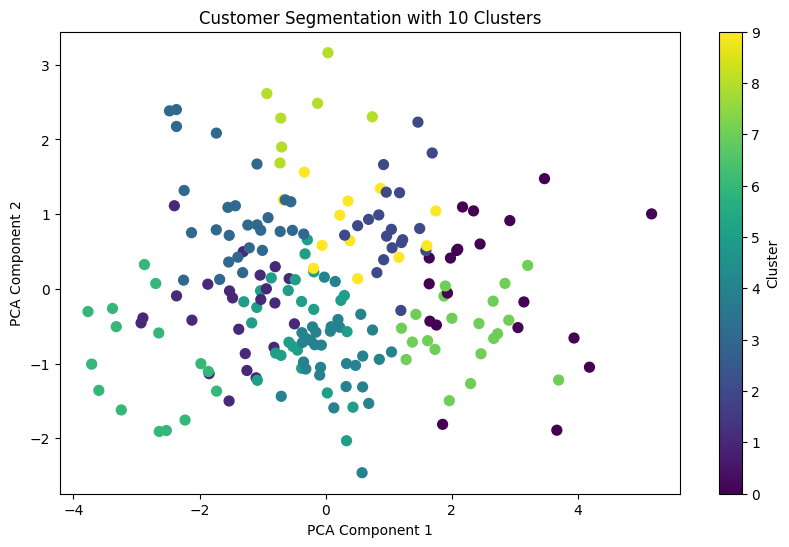

In [94]:
# Visualize clusters
plt.figure(figsize=(10, 6))

# Create the scatter plot and store the result
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=customer_data["Cluster"], cmap="viridis", s=50)

plt.title(f"Customer Segmentation with {optimal_clusters} Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Add a colorbar, explicitly linking it to the scatter plot
plt.colorbar(scatter, label="Cluster")

In [95]:
plt.show()

In [96]:
# Save customer clustering data to a CSV
customer_data[["CustomerID", "Cluster"]].to_csv("Customer_Segmentation.csv", index=False)
print("Customer segmentation saved as 'Customer_Segmentation.csv'!")


Customer segmentation saved as 'Customer_Segmentation.csv'!


In [98]:
!pip install fpdf  # Install the fpdf package
from fpdf import FPDF

# Initialize PDF
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.add_page()

# Add title
pdf.set_font("Arial", size=16)
pdf.cell(200, 10, txt="Customer Segmentation Report", ln=True, align="C")
pdf.ln(10)

# Add clustering details
pdf.set_font("Arial", size=12)
pdf.multi_cell(0, 10, txt=(
    f"Clustering Results:\n"
    f"1. Number of Clusters: {optimal_clusters}\n"
    f"2. Davies-Bouldin Index: {final_db_index:.2f}\n"
    f"3. Clustering performed using KMeans algorithm with the following features:\n"
    f"   - TotalSpent\n"
    f"   - TotalTransactions\n"
    f"   - TotalQuantity\n"
    f"   - AvgTransactionValue\n"
    f"   - Region\n"
))
pdf.ln(5)

# Add insights
pdf.multi_cell(0, 10, txt=(
    "Insights:\n"
    "1. The clustering algorithm grouped customers into distinct segments based on their spending patterns, transaction behavior, and regional preferences.\n"
    "2. Cluster 0 represents high-value customers who spend the most and have frequent transactions.\n"
    "3. Cluster 1 represents moderate-value customers with average spending and transaction frequency.\n"
    "4. Regional preferences and average transaction values were significant factors in forming clusters.\n"
))
pdf.ln(5)

# Save PDF
pdf.output("Customer_Segmentation_Report.pdf")
print("PDF report saved as 'Customer_Segmentation_Report.pdf'")

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=c284b45b832da74dee47c3d10678877ed49c173197f0b62fa9ea05bd4de0daeb
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf
PDF report saved as 'Customer_Segmentation_Report.pdf'
